In [169]:
import torch
import optuna
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pathlib

In [170]:
def df_to_X_y_vector(df, lags, future):
    X = []
    y = []
    for i in range(len(df) - lags - future):
        x_window_rows = df.iloc[i:i + lags]
        x_row = [list(x_window_rows.iloc[j]) for j in range(lags)]
        X.append(x_row)
        y_window_rows = df.iloc[i + lags:i + lags + future]
        y_row = [y_window_rows.iloc[j]['Detections'] for j in range(future)]
        y.append(y_row)
    return np.array(X), np.array(y)

In [171]:
def get_df(path):
    df = pd.read_csv(path)
    df = df.drop(['WeatherDescription', 'Unnamed: 0', 'index'], axis=1)
    df = pd.get_dummies(df, columns=['WeatherMain'], prefix='WeatherMain')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Year'] = df['Timestamp'].dt.year
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    df['Hour'] = df['Timestamp'].dt.hour
    df = df.drop(['Timestamp', 'WeatherMain_Snow', 'Year'], axis=1)
    return df_to_X_y_vector(df, 288, 288)

In [172]:
# path = '../../train_belgrade.csv'
# X, y = get_df(path)
# X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
# X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# # X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [173]:
# # save all data to csv files and save the shape of the data
# pathlib.Path('data').mkdir(parents=True, exist_ok=True)
# np.savetxt('data/X_train_raw.csv', X_train_raw.reshape(X_train_raw.shape[0], -1), delimiter=',')
# np.savetxt('data/y_train_raw.csv', y_train_raw, delimiter=',')
# np.savetxt('data/X_val_raw.csv', X_val_raw.reshape(X_val_raw.shape[0], -1), delimiter=',')
# np.savetxt('data/y_val_raw.csv', y_val_raw, delimiter=',')
# np.savetxt('data/X_test_raw.csv', X_test_raw.reshape(X_test_raw.shape[0], -1), delimiter=',')
# np.savetxt('data/y_test_raw.csv', y_test_raw, delimiter=',')


In [174]:
# load data from csv files
X_train_raw = np.loadtxt('data/X_train_raw.csv', delimiter=',').reshape(-1, 288, 8)
y_train_raw = np.loadtxt('data/y_train_raw.csv', delimiter=',')
X_val_raw = np.loadtxt('data/X_val_raw.csv', delimiter=',').reshape(-1, 288, 8)
y_val_raw = np.loadtxt('data/y_val_raw.csv', delimiter=',')
X_test_raw = np.loadtxt('data/X_test_raw.csv', delimiter=',').reshape(-1, 288, 8)
y_test_raw = np.loadtxt('data/y_test_raw.csv', delimiter=',')
print(X_train_raw.shape, y_train_raw.shape, X_val_raw.shape, y_val_raw.shape, X_test_raw.shape, y_test_raw.shape)

(11248, 288, 8) (11248, 288) (1406, 288, 8) (1406, 288) (1407, 288, 8) (1407, 288)


In [175]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [176]:
X_train = torch.tensor(X_train_raw, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_raw, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_raw, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_raw, dtype=torch.float32).to(device)


X_train = X_train.permute(0, 2, 1)
X_val = X_val.permute(0, 2, 1)


print(X_train.shape, y_train.shape)

torch.Size([11248, 8, 288]) torch.Size([11248, 288])


In [177]:
class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, **kwargs):
        super().__init__()
        self.last_layer = kwargs.pop('last_layer', False)
        self.lstm = nn.GRU(input_dim, hidden_size, **kwargs)

    def forward(self, x):
        output, _ = self.lstm(x)
        if self.last_layer:
            return output[:, -1, :]
        return output


In [178]:
class ForecastModel(nn.Module):
    def __init__(self, trial, input_dim, output_dim):
        super().__init__()
        self.num_layers = trial.suggest_int('num_layers', 1, 3)
        self.dropout = trial.suggest_float('dropout', 0.1, 0.5)
        self.hidden_size = trial.suggest_int('hidden_size', 16, 128)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rnn_layers = []
        self.conv = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=24, stride=6)
        # calculate the input size for the first layer
        first_input_dim = (288 - 24) // 6 + 1
        for i in range(self.num_layers):
            input_size = self.hidden_size if i != 0 else first_input_dim
            self.rnn_layers.append(CustomLSTM(input_size, self.hidden_size, batch_first=True))
            self.rnn_layers.append(nn.Dropout(self.dropout))
        self.rnn_layers = nn.ModuleList(self.rnn_layers)
        self.flattned_size = self.hidden_size * input_dim
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.flattned_size, self.output_dim)
        

    def forward(self, x):
        x = self.conv(x)
        for layer in self.rnn_layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [179]:


def create_model(trial, input_size, output_size):
    # Hyperparameters to be tuned
    hidden_size = trial.suggest_int('hidden_size', 50, 200)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    layers = []

    # in_channels = 288
    # out_channels = 8
    # kernel_size = 12
    layers.append(nn.Conv1d(in_channels=8, out_channels=8, kernel_size=24))
    layers.append(nn.ReLU())
    # layers.append(nn.MaxPool1d(kernel_size=2))
    # layers.append(nn.Flatten())

    input_dim = 288 - 24 + 1
    for i in range(num_layers):
        input_dim = input_dim if i == 0 else hidden_size
        layers.append(CustomLSTM(input_dim, hidden_size, batch_first=True, dropout=dropout if i+1 < num_layers else 0, last_layer=i+1 == num_layers))
    layers.append(nn.Linear(hidden_size, output_size))
    
    model = nn.Sequential(*layers).to(device)
    return model


In [180]:
trial_data = {}

In [181]:
def objective(trial):
    # Assuming data preparation steps are already done, and you have X_train, y_train, X_val, y_val as tensors
    # print('Inputs:', X_train.shape, y_train.shape)
    
    model = ForecastModel(trial, input_dim=8, output_dim=288).to(device)

    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-4, 1e-2, log=True))
    
    # Example: Train the model
    epochs = 10
    mini_batch_size = 32
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i in range(0, len(X_train), mini_batch_size):
            optimizer.zero_grad()
            X_batch = X_train[i:i+mini_batch_size]
            y_batch = y_train[i:i+mini_batch_size]
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            # loss is a vector of size mini_batch_size, we need to sum it up
            # print(loss.item())
            train_loss += loss.item()
        train_losses.append(train_loss / len(range(0, len(X_train), mini_batch_size)))
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
    
    trial_data[trial.number] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {val_loss.item()}')
    # save model
    output_path = pathlib.Path('./lstm_models')
    output_path.mkdir(exist_ok=True)
    torch.save(model.state_dict(), output_path/f'model_{trial.number}.pth')

            
    return val_loss.item()


In [182]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
print(f'Best trial score: {best_trial.value}')
for key, value in best_trial.params.items():
    print(f'{key}: {value}')


[I 2024-04-04 01:50:22,609] A new study created in memory with name: no-name-1fd80bb2-26ee-4327-bb88-d191e4c437e1
[I 2024-04-04 01:50:56,545] Trial 0 finished with value: 15.87326717376709 and parameters: {'num_layers': 3, 'dropout': 0.10766421542116072, 'hidden_size': 96, 'lr': 0.0007667553700291956}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 15.87326717376709


[I 2024-04-04 01:51:19,002] Trial 1 finished with value: 24.962934494018555 and parameters: {'num_layers': 2, 'dropout': 0.3552523363955459, 'hidden_size': 79, 'lr': 0.00010214328717690952}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 24.962934494018555


[I 2024-04-04 01:51:53,434] Trial 2 finished with value: 20.40757942199707 and parameters: {'num_layers': 3, 'dropout': 0.21248243486001878, 'hidden_size': 94, 'lr': 0.00015731396869430873}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 20.40757942199707


[I 2024-04-04 01:52:08,625] Trial 3 finished with value: 20.824316024780273 and parameters: {'num_layers': 1, 'dropout': 0.4525615025726242, 'hidden_size': 98, 'lr': 0.002607399286287793}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 20.824316024780273


[I 2024-04-04 01:52:38,017] Trial 4 finished with value: 21.448104858398438 and parameters: {'num_layers': 2, 'dropout': 0.35103173840463, 'hidden_size': 116, 'lr': 0.004824927289817505}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 21.448104858398438


[I 2024-04-04 01:53:01,904] Trial 5 finished with value: 21.773757934570312 and parameters: {'num_layers': 2, 'dropout': 0.3850972364108597, 'hidden_size': 89, 'lr': 0.0001864734241491518}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 21.773757934570312


[I 2024-04-04 01:53:27,980] Trial 6 finished with value: 17.82254981994629 and parameters: {'num_layers': 2, 'dropout': 0.31590993571068215, 'hidden_size': 100, 'lr': 0.002278883567020693}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 17.82254981994629


[I 2024-04-04 01:53:50,033] Trial 7 finished with value: 17.206832885742188 and parameters: {'num_layers': 2, 'dropout': 0.1879230808135461, 'hidden_size': 77, 'lr': 0.0006705423810672645}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 17.206832885742188


[I 2024-04-04 01:54:15,615] Trial 8 finished with value: 23.393428802490234 and parameters: {'num_layers': 2, 'dropout': 0.12952322651019862, 'hidden_size': 93, 'lr': 0.007948249126189825}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 23.393428802490234


[I 2024-04-04 01:54:38,356] Trial 9 finished with value: 18.906030654907227 and parameters: {'num_layers': 2, 'dropout': 0.1931259687856176, 'hidden_size': 83, 'lr': 0.0003261002142439217}. Best is trial 0 with value: 15.87326717376709.


Epoch 10/10, Loss: 18.906030654907227
Best trial score: 15.87326717376709
num_layers: 3
dropout: 0.10766421542116072
hidden_size: 96
lr: 0.0007667553700291956


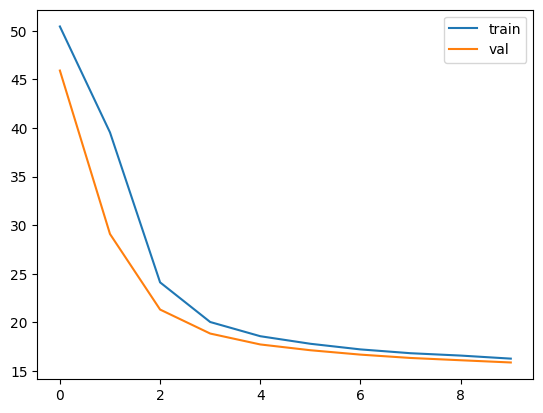

In [183]:
import matplotlib.pyplot as plt
plt.plot(trial_data[best_trial.number]['train_losses'], label='train')
plt.plot(trial_data[best_trial.number]['val_losses'], label='val')
plt.legend()
plt.show()

In [184]:
# evaluate on test set
X_test = torch.tensor(X_test_raw, dtype=torch.float32)
X_test = X_test.permute(0, 1, 2)
y_test = torch.tensor(y_test_raw, dtype=torch.float32)

criterion = nn.MSELoss()


In [185]:
# best_trial = {'num_layers': 2, 'dropout': 0.3907331240770967, 'hidden_size': 127, 'lr': 0.0004603846594084274}

In [189]:
best_trial.number

0

In [186]:
0.0004 == 4e-4

True

In [192]:

model = ForecastModel(best_trial, input_dim=8, output_dim=288).to(device)
model.eval()
model.load_state_dict(torch.load(f'./lstm_models/model_0.pth'))


<All keys matched successfully>

In [193]:
best_trial.number

0

In [ ]:
import torch.onnx

# Export the model
torch.onnx.export(model,               # model being run
                  torch.randn(1, 8, 288),                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})


/mnt/ACA058A9A0587C30/Faks/Master/SIAP-NM/venv/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [194]:

with torch.no_grad():
    # reshape the data
    X_test = X_test.permute(0, 2, 1)
    test_output = model(X_test.to(device))
    
    test_loss = criterion(test_output, y_test.to(device))
    
print(f'Test loss: {test_loss.item()}')


Test loss: 16.031246185302734


In [195]:
X_test.shape

torch.Size([1407, 8, 288])

In [196]:
print(best_trial.params)

{'num_layers': 3, 'dropout': 0.10766421542116072, 'hidden_size': 96, 'lr': 0.0007667553700291956}


In [197]:

for i in range(10):
    for j in range(0, len(y_test[i]), 24):
        print(f'Predicted: {test_output[i][j].item()}, True: {y_test[i][j].item()}')

    

Predicted: 17.810340881347656, True: 16.0
Predicted: 17.110191345214844, True: 17.0
Predicted: 14.925853729248047, True: 13.0
Predicted: 10.089225769042969, True: 20.0
Predicted: 5.856027603149414, True: 1.0
Predicted: 2.270090341567993, True: 0.0
Predicted: 2.0582404136657715, True: 0.0
Predicted: 11.34364128112793, True: 11.0
Predicted: 18.77197265625, True: 21.0
Predicted: 19.053163528442383, True: 21.0
Predicted: 17.50364875793457, True: 15.0
Predicted: 17.550827026367188, True: 20.0
Predicted: 18.534656524658203, True: 16.0
Predicted: 18.880550384521484, True: 18.0
Predicted: 20.138107299804688, True: 20.0
Predicted: 17.924076080322266, True: 21.0
Predicted: 16.299278259277344, True: 14.0
Predicted: 15.949607849121094, True: 15.0
Predicted: 13.426313400268555, True: 9.0
Predicted: 10.643196105957031, True: 16.0
Predicted: 6.588159561157227, True: 4.0
Predicted: 3.603935480117798, True: 0.0
Predicted: 3.9607248306274414, True: 0.0
Predicted: 11.968009948730469, True: 14.0
Predicted

In [198]:
arr = y_test.detach().cpu().numpy()
smoothed_arr = np.empty_like(arr)

smoothed_arr = np.zeros_like(arr)
alpha = 0.8


In [199]:
print(arr.shape)

(1407, 288)


In [200]:

for i in range(1):
    moving_avg = arr[i, 0]
    for j in range(arr.shape[1]):
        moving_avg = moving_avg * alpha + arr[i, j] * (1 - alpha)
        smoothed_arr[i, j] = moving_avg


In [ ]:
print(smoothed_arr)

[[16.       16.4      16.12     ... 16.421358 16.337086 16.269669]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [ ]:
smoothed_arr[0]

In [ ]:
print(smoothed_arr.shape)

(1407, 288)


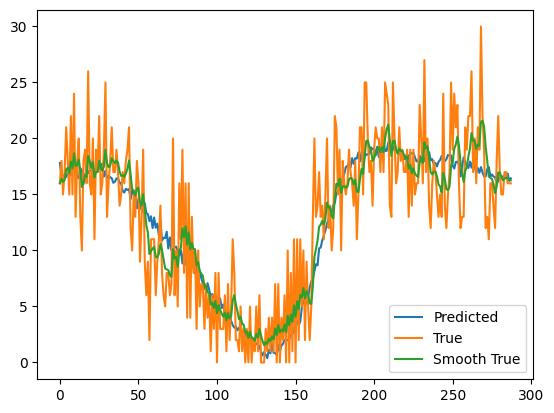

In [201]:
# plot the results
import matplotlib.pyplot as plt
plt.plot(test_output[0].cpu().numpy(), label='Predicted')
plt.plot(y_test[0].cpu().numpy(), label='True')
plt.plot(smoothed_arr[0], label='Smooth True')
plt.legend()
plt.show()
